## Домашнее задание по NLP №2

**Описание задания:**
1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
2. Обучите по коллекции предложений word2vec

3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    - тест на определение ближайших слов
    - тест на аналогии (мужчина – король : женщина – королева)
    - тест на определение лишнего слова.

4. Постройте несколько визуализаций:
    - TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    - задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from pymystem3 import Mystem
import seaborn as sns
import json
import bz2
import regex
from nltk import FreqDist
from sklearn.manifold import TSNE
from tqdm import tqdm
from scipy import sparse
from collections import Counter
import re
import gensim
import logging
import nltk.data 
import requests
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
from string import punctuation
import urllib.request
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models import word2vec
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from rusenttokenize import ru_sent_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
nltk.download('punkt')
%matplotlib inline
%pylab inline

/home/dev/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package punkt to /home/dev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Загрузим данные:

In [2]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:58, 1690.25it/s] 


In [3]:
responses[0]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Жалоба',
 'num_comments': 0,
 'bank_license': 'лицензия № 2562',
 'author': 'uhnov1',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-08 12:50:54',
 'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удо

In [4]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


#### 1. Разобьем всю коллекцию отзывов на предложения. Лемматизируем все слова.

In [5]:
def lemmatize(text):      # лемматизируем текст и объединим элементы списка в строку, которую получим на выходе
    m = Mystem()
    lemm_text = []
    for row in text:
        lemmas = ' '.join(m.lemmatize(row))
        lemm_text.append(lemmas.split())
    return lemm_text


def clear_text(text):     # очистим строки при помощи регулярных выражений: оставим только буквы.
    new_text = (re.sub(r'[^а-яА-Я]', ' ', text)).lower()
    return " ".join(new_text.split())

In [6]:
def sentences(text):    # разделим на предложения, попутно очищая текст от знаков и преобразуя его к нижнему регистру
    try:
        return [clear_text(sent) for sent in ru_sent_tokenize(text)]
    except:
        return []

In [7]:
from nltk.corpus import stopwords
stopwords = stopwords.words('russian') + ['-', 'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 'г', 'Добрый день', 'Здравствуйте', 'доброго', 'дня', 'добрый', 'день', 'здравствуйте', 'В', 'тут-то', 'было', 'На', 'чуть-чуть', 'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'Как', 'без', 'рэ']

def remove_stopwords(sentences, stopwords = stopwords): # уберем стоп-слова
    try:
        out = []
        for sentence in sentences:
            out.append(" ".join([token for token in sentence.split() if not token in stopwords]))
        return out
    except:
        return []

In [8]:
stoplemmas = ['день', 'данный', 'который', 'ваш', 'свой', 'месяц', 'какой', 'сей', 'наш', 'мочь']

def remove_stoplemmas(sentences):  # уберем стоп-леммы
    res = []
    if len(sentences) > 0:
        res.append([lemma for lemma in sentences if not lemma in stoplemmas])
    return res

In [9]:
def preprocessing(text):     # вызовем все функции в одной
    sents = sentences(text)
    no_stopwords = remove_stopwords(sents)
    lemmas = lemmatize(no_stopwords)
    no_stoplemmas = remove_stoplemmas(lemmas)
    flat_lemmas = [x for sentence in no_stoplemmas for sublist in sentence for x in sublist]
    return flat_lemmas

In [10]:
preprocessing(df.text[0])

['являться',
 'клиент',
 'банк',
 'поручитель',
 'кредитный',
 'договор',
 'являться',
 'какой',
 'либо',
 'другой',
 'лицо',
 'письменно',
 'оформлять',
 'отношение',
 'банк',
 'повод',
 'урегулирование',
 'чей',
 'либо',
 'задолженность',
 'начинать',
 'марта',
 'год',
 'начинать',
 'приходить',
 'бесконечный',
 'письмо',
 'ооо',
 'примо',
 'коллект',
 'адрес',
 'город',
 'москва',
 'уваровский',
 'переулок',
 'дом',
 'квартира',
 'угроза',
 'возбуждение',
 'уголовный',
 'дело',
 'отношение',
 'гражданин',
 'филиппов',
 'эдуард',
 'владимирович',
 'который',
 'уклоняться',
 'уплата',
 'взять',
 'кредит',
 'договор',
 'год',
 'договор',
 'год',
 'весь',
 'ответственность',
 'хотеть',
 'заверять',
 'вышеуказанный',
 'гражданин',
 'который',
 'разыскивать',
 'знакомый',
 'мой',
 'адрес',
 'зарегистрировать',
 'какой',
 'образ',
 'удостоверяться',
 'подлинность',
 'документ',
 'оформлять',
 'имя',
 'кредитный',
 'договор',
 'меньший',
 'мера',
 'понятно',
 'почему',
 'ваш',
 'милость',
 

In [11]:
%%time
df["lemmatize"] = df.text.progress_apply(preprocessing)

100%|██████████| 153499/153499 [41:10:07<00:00,  1.04it/s]     

CPU times: user 10min 47s, sys: 2h 17min 35s, total: 2h 28min 23s
Wall time: 1d 17h 10min 7s


In [12]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,lemmatize
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,"[являться, клиент, банк, поручитель, кредитный..."
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,"[являться, держатель, зарплатной, карта, выдав..."
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,"[дублировать, свой, заявление, можайский, я, м..."
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,"[открывать, расчетный, счет, сбербанк, юр, лиц..."
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,"[взять, кредит, ваш, банк, заявлять, я, сумма,..."


In [17]:
df.to_csv('data_with_lemmatize.csv', index=False)

#### 2. Обучим по коллекции предложений word2vec

In [13]:
urllib.request.urlretrieve("http://rusvectores.org/static/models/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz", "ruscorpora_mystem_cbow_300_2_2015.bin.gz")

('ruscorpora_mystem_cbow_300_2_2015.bin.gz',
 <http.client.HTTPMessage at 0x7fe9a029e130>)

In [14]:
model_path = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

model_ru = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

Открываем получившийся файл с лемматизацией:

In [2]:
data = pd.read_csv('data_with_lemmatize.csv')
data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,lemmatize
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,"['являться', 'клиент', 'банк', 'поручитель', '..."
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,"['являться', 'держатель', 'зарплатной', 'карта..."
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,"['дублировать', 'свой', 'заявление', 'можайски..."
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,"['открывать', 'расчетный', 'счет', 'сбербанк',..."
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,"['взять', 'кредит', 'ваш', 'банк', 'заявлять',..."


Поскольку в столбце "lemmatize" у нас строка с списком, придется ее обработать:

In [3]:
lst_lemm = []
for i in range(len(data)):
    lst_lemm.append(data.lemmatize[i][1:-1].replace("'", '').split(", "))
data['lemma'] = lst_lemm

Теперь можно определить токены и выбрать топ-10 наиболее частых лемм:

In [26]:
cnt_lemmas = Counter()
n_types_lemmas = []
n_tokens_lemmas = []
tokens_lemmas = []
for index, row in tqdm(data.iterrows(), total = len(data)):
    tokens = row['lemma']
    cnt_lemmas.update(tokens)
    n_types_lemmas.append(len(cnt_lemmas))
    n_tokens_lemmas.append(sum(list(cnt_lemmas.values())))
    tokens_lemmas.append(tokens)
print('Топ-10 наиболее часто встречающихся лемм:')
for i in cnt_lemmas.most_common(10):    
    print(i)

100%|██████████| 153499/153499 [15:18<00:00, 167.18it/s]    

Топ-10 наиболее часто встречающихся лемм:
('банк', 623310)
('карта', 334996)
('деньги', 179734)
('мой', 163042)
('кредит', 156177)
('который', 148983)
('отделение', 144050)
('клиент', 136892)
('сотрудник', 134168)
('счет', 126894)


Работаем с моделью Word2Vec:

In [24]:
%%time
print("Обучаем модель...")

model = word2vec.Word2Vec(sentences=data['lemma'], workers=4, min_count=20, window=20)

Обучаем модель...
CPU times: user 7min 57s, sys: 5.37 s, total: 8min 2s
Wall time: 2min 10s


И сохраняем модель:

In [25]:
model.save('model_rus_w2vec.model')

#### 3. Приведём несколько удачных и неудачных примеров решения стандартных текстов для word2vec:

- тест на определение ближайших слов

Посмотрим на примеры слов:

In [26]:
words = ['банк', 'деньги', 'кредит', 'страховка', 'являться', 'карта', 'ипотека']

In [29]:
for word in words:
    try:
        print('Топ-3 ближайших соседа для слова "%s":' % word)
        print(model.wv.most_similar(word, topn=3))
        print()
    except:
        print('Слова "%s" нет в модели!' % word)

Топ-3 ближайших соседа для слова "банк":
[('банка', 0.815872311592102), ('банкинг', 0.4088098108768463), ('перфект', 0.36333519220352173)]

Топ-3 ближайших соседа для слова "деньги":
[('денежки', 0.7027667164802551), ('обратно', 0.6901535987854004), ('денежка', 0.64412921667099)]

Топ-3 ближайших соседа для слова "кредит":
[('потребкредит', 0.7040748596191406), ('автокредит', 0.6886087656021118), ('ссуда', 0.6479224562644958)]

Топ-3 ближайших соседа для слова "страховка":
[('страхование', 0.8015092611312866), ('страховаться', 0.7088545560836792), ('застраховываться', 0.7014257311820984)]

Топ-3 ближайших соседа для слова "являться":
[('почетный', 0.5652843713760376), ('давний', 0.5498329997062683), ('лояльный', 0.533713698387146)]

Топ-3 ближайших соседа для слова "карта":
[('карточка', 0.7159038186073303), ('дебетовый', 0.6432629227638245), ('именной', 0.6193267107009888)]

Топ-3 ближайших соседа для слова "ипотека":
[('новостройка', 0.7499034404754639), ('ипотечный', 0.7363129258155

Что можно сказать: для слова "кредит" ближайшие слова вполне логичны, для слов "страховка" и "карта" - тоже, чего не скажешь, например, о словах "банк" (причем тут "перфект"?), "деньги" (слово "обратно", возможно, используется довольно часто рядом со словом "деньги", но смысл имеет совсем иной). Касаемо слова "ипотека" тоже всё неоднозначно: с одной стороны, слова действительно близки, но с другой - сильно разнятся. Особенно если сравнить, например, со словом ""кредит".

- тест на аналогии (мужчина – король : женщина – королева)

Напишем 2 функции: в одной мы будем подбирать аналоги для слов, складывая и вычитая векторы слов, в другой красиво выводить результат:

In [30]:
def pp(obj):
    print(pd.DataFrame(obj))
    
def analogy(worda, wordb, wordc):
    result = model.wv.most_similar(negative=[worda], 
                                positive=[wordb, wordc])
    return result[0][0]

Подберем аналоги для названий банков. Опираемся на слово "кредит":

In [40]:
banks = ['втб', 'альфа', 'открытие', 'тинькофф']
cred = [analogy('сбербанк', 'вклад', bank) for bank in banks]
pp(zip(banks, cred))

          0           1
0       втб     депозит
1     альфа     депозит
2  открытие  депозитный
3  тинькофф         ткс


Еще можно посмотреть на аналоги для оплаты в разных валютах:

In [55]:
words = ['доллар', 'евро']
res = [analogy('рубль', 'кредит', word) for word in words]
pp(zip(words, res))

        0           1
0  доллар     ипотека
1    евро  автокредит


И еще посмотрим, какие банки представлены в городах на лидирующих позициях:

In [48]:
cities = ['петербург', 'ростов', 'самара', 'владивосток']
res = [analogy('москва', 'втб', city) for city in cities]
pp(zip(cities, res))

             0              1
0    петербург  петербургский
1       ростов            ткб
2       самара            ткб
3  владивосток    транскредит


В целом аналогии определяются достаточно правдоподобно. Если для Сбербанка мы использовали слово "вклад", то для остальных модель подобрала действительно схожие понятия.  
Также любопытно, что для валют подобрались достаточно необычные аналогии: для доллара, например, приведена аналогия "ипотека" (что, кстати, вполне возможно), а для евро - "автокредит" (тоже вероятно).  
Еще интересно, что в Санкт-Петербурге среди первых находится банк "Санкт-Петербург" (иначе "Петербургский"), во Владивостоке - "Транскредит".   
Хочу обратить внимание, что мы не брали в данном случае лидера - "Сбербанк", поскольку во всех городах он занимает первую строчку рейтинга популярных, и, соответственно, при запуске аналогий вышло бы только одно значение - имя этого банка, а это не интересно)

- тест на определение лишнего слова.

In [33]:
model.wv.doesnt_match('рубль кредит доллар евро'.split())

'кредит'

Да, модель определила верно: среди валют лишнее слово "кредит".

In [34]:
model.wv.doesnt_match('авто купить дом'.split())

'дом'

Здесь можно поспорить: логичнее было бы обозначить лишним слово "купить", поскольку оно обозначает действие, а остальные слова - объекты.

In [52]:
model.wv.doesnt_match('кредит страховка банк взнос'.split())

'банк'

Здесь тоже довольно логично: речь идет о некоторых продуктах банка. Сам же "банк" лишний.

#### 4. Построим несколько визуализаций:

- TSNE для топ-100 слов; найдём осмысленные кластеры слов

Выберем 100 самых частотных слов (почему не 500: не наглядно получается):

In [27]:
top_words = []

fd = FreqDist()
for text in tqdm(data.lemma):
    fd.update(text)
for i in fd.most_common(100):
    top_words.append(i[0])
print(top_words[:10])

100%|██████████| 153499/153499 [00:17<00:00, 8655.33it/s] 


['банк', 'карта', 'деньги', 'мой', 'кредит', 'который', 'отделение', 'клиент', 'сотрудник', 'счет']


In [28]:
top_words_vec = model.wv[top_words]

In [29]:
%%time
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

CPU times: user 6min 39s, sys: 2.43 s, total: 6min 42s
Wall time: 20 s


In [30]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE (eng model, top1000 words)",
        plot_width=990, plot_height=800)

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

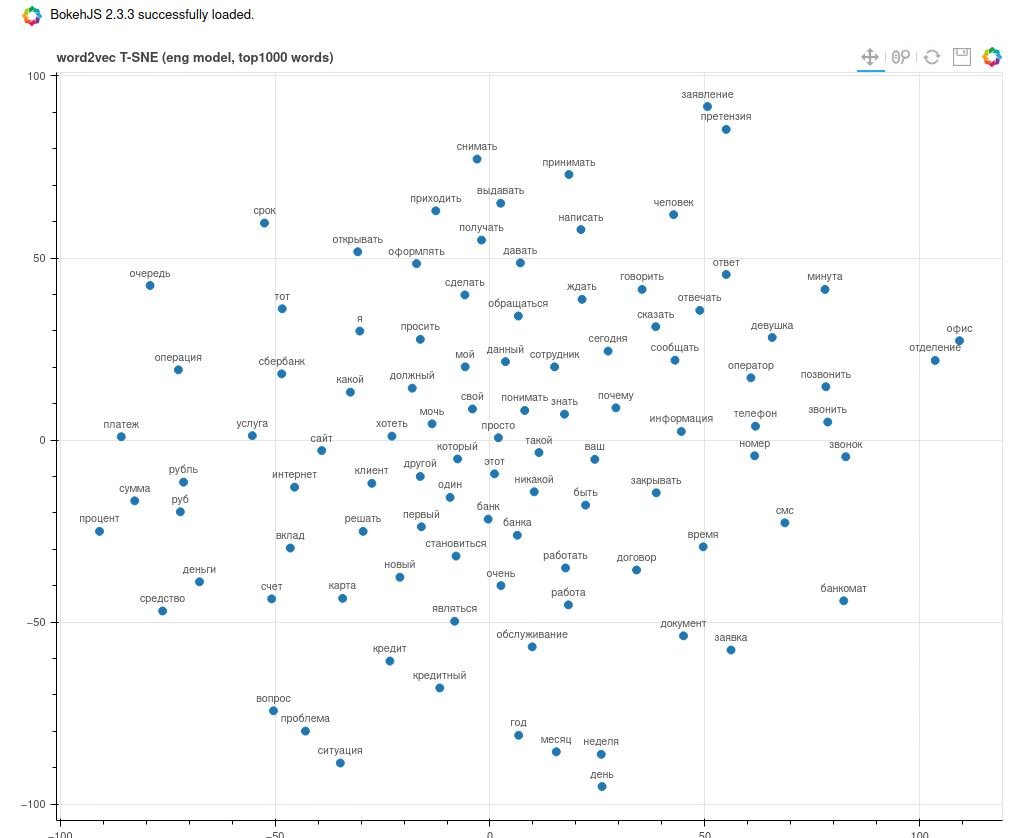

In [1]:
from IPython.display import Image
Image(filename='Топ-100 слов.JPG') 

1) Итак, снизу виден кластер с временными промежутками: "день", "неделя", "месяц", "год"  
2) Также выделяются из общей картины два слова, находящиеся близко друг к другу: "заявление" и "претензия" (сверху чуть правее центра). Действительно, логичное соседство  
3) Обратим внимание на кластер слева: "платеж", "рубль", "руб", "сумма", "процент"  
4) В центре сосредоточены местоимения, союзы и глаголы действия. Самый обширный кластер  
5) Немного выше и правее кластера с временем еще одно интересное соседство: "документ" и "заявка"  
6) Также обратим внимание на кластер справа в середине: "офис" и "отделение". Тут собрались 2 слова - синонима  
6) И заметим еще один момент: "вопрос", "проблема" и "ситуация" также обособлены от других.

- задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

Инициализируем и обучаем модель FastText:

In [4]:
%%time
from gensim.models import FastText
print("Обучаем модель...")

model_fasttext = FastText(data.lemma, window=10, min_count=4, workers=4, sg=1)

CPU times: user 1h 20min 57s, sys: 18.4 s, total: 1h 21min 16s
Wall time: 20min 37s


Определяем векторы "хорошо" и "плохо" и вычитаем один из другого:

In [12]:
good_word = model_fasttext.wv.get_vector("хорошо")
bad_word = model_fasttext.wv.get_vector("плохо")

result_x = good_word - bad_word
result_x   # разница между хорошим и плохим словом

array([-0.03213779,  0.13880034, -0.09704171,  0.29925036, -0.00391218,
       -0.02092218, -0.20501551, -0.28430876,  0.01621612, -0.12357169,
       -0.16307259,  0.19399597,  0.16317737,  0.16671376,  0.1832147 ,
        0.29731542, -0.04061182,  0.146242  ,  0.19718643, -0.07646781,
        0.12760817, -0.05175817, -0.1938228 , -0.44051704,  0.25979745,
        0.35469723,  0.19267687,  0.3220304 , -0.18967447, -0.00692055,
        0.089867  ,  0.27514264, -0.23702106, -0.09502353, -0.12350908,
       -0.33763877, -0.01887317, -0.0057022 ,  0.19550073, -0.31228563,
        0.02349821, -0.17958447,  0.14590009, -0.24955216, -0.03404817,
        0.09921888,  0.11414939,  0.22211653, -0.1145695 ,  0.07983749,
       -0.15290636,  0.26452535,  0.1353492 ,  0.04844174,  0.06369852,
       -0.14666897, -0.07870676, -0.06909172, -0.06965242,  0.12631987,
        0.21779287, -0.01093607, -0.09771359, -0.0110269 ,  0.24540743,
        0.2209961 ,  0.06462979, -0.14399388, -0.28487596, -0.05

И то же самое для "быстро-медленно":

In [13]:
fast_word = model_fasttext.wv.get_vector("быстро")
slow_word = model_fasttext.wv.get_vector("медленно")

result_y = fast_word - slow_word
result_y   # разница между быстрым и медленным словом

array([-0.15678778,  0.23661852,  0.15257959,  0.19189867, -0.23046534,
        0.22164977,  0.11170013, -0.16602011, -0.02851787,  0.05990962,
        0.29947734,  0.24833637,  0.3668705 ,  0.09837219, -0.27417994,
        0.00839881,  0.04847297,  0.08197311,  0.12395053, -0.16230585,
       -0.0934346 ,  0.18783139,  0.1227835 ,  0.10229422, -0.12969604,
        0.0428426 ,  0.32420254,  0.23790616, -0.14063697,  0.30530435,
       -0.2547769 ,  0.27320722,  0.5982088 ,  0.2544321 ,  0.11221406,
       -0.24961033, -0.12442966,  0.13420758,  0.5168907 , -0.1620006 ,
       -0.23675677, -0.6389228 ,  0.33305392, -0.6106539 ,  0.37674305,
       -0.07600784, -0.0036647 , -0.01517764, -0.36997622, -0.19404842,
       -0.03478002, -0.06336835,  0.12726091, -0.2518632 ,  0.11898614,
       -0.37639078,  0.03895919, -0.10537937, -0.33371237,  0.4322617 ,
       -0.04412854, -0.4661913 ,  0.21715054, -0.07101481,  0.0010341 ,
        0.35761684,  0.09285919, -0.09982337, -0.01072255,  0.29

Теперь вспомним, какие банки есть и какие именно присутствуют в данном наборе:

In [14]:
banks = [i.lower() for i in data.bank_name.unique().tolist()]
banks[:10], len(banks)

(['бинбанк',
  'сбербанк россии',
  'отп банк',
  'гагаринский',
  'тинькофф банк',
  'восточный экспресс банк',
  'втб 24',
  'альфа-банк',
  'бинбанк кредитные карты',
  'мтс банк'],
 670)

Всего у нас 82 банка, что не очень хорошо скажется на наглядности построенного плота. Поэтому возьмем мы только первые 20:

In [15]:
values_x = []    #  положение банков по оси х
values_y = []    #  положение банков по оси у
for i in banks[:20]:
    x = (model_fasttext.wv.get_vector('{}'.format(i)) * result_x).mean()   #  возьмем среднее для х
    y = (model_fasttext.wv.get_vector('{}'.format(i)) * result_y).mean()   #  возьмем среднее для у
    values_x.append(x)
    values_y.append(y)

И визуализация:

In [16]:
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE (rus model, banks work quality, +SVD)",
          plot_width=990, plot_height=800)

source = ColumnDataSource(data=dict(x1=values_x,
                                    x2=values_y,
                                    names=banks[:20]))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

p.xaxis.axis_label = "<=  Плохо                       ...                       Хорошо  =>"
p.yaxis.axis_label = "<=  Медленно                     ...                       Быстро  =>"

show(p)

Loading BokehJS ...

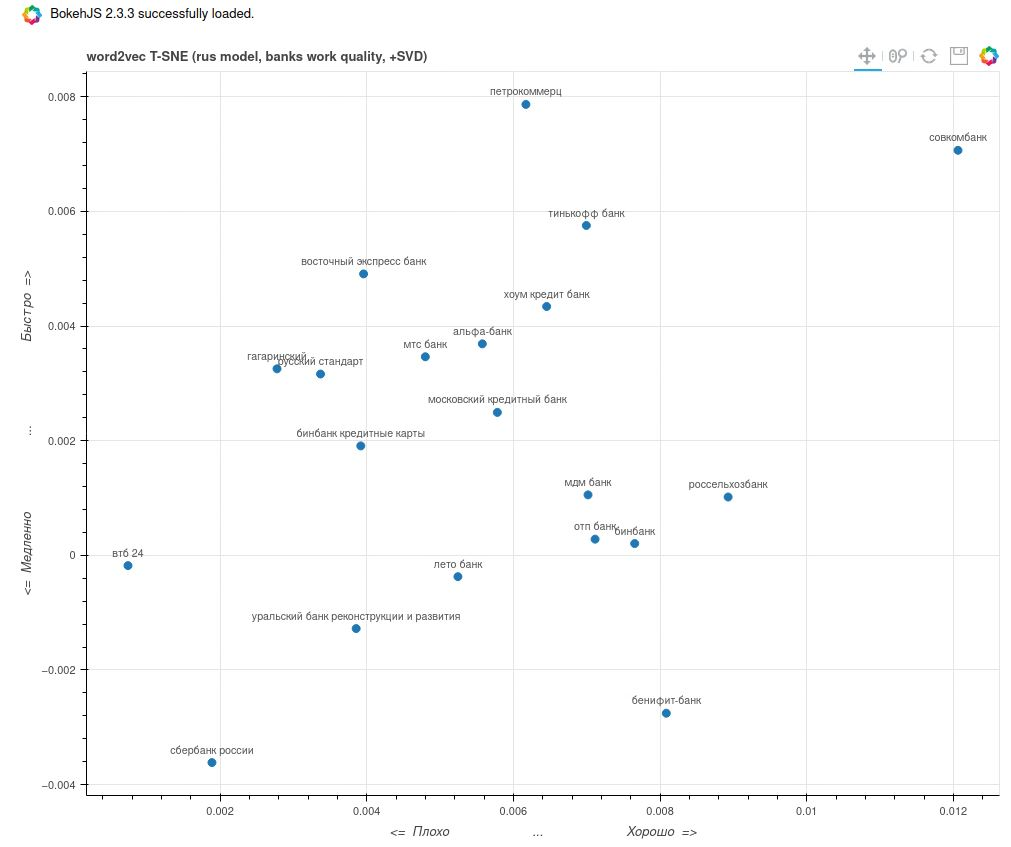

In [2]:
Image(filename='Банки.JPG') 

Что мы видим: больше всего негативных слов было о работе банков "Сбербанк" и "ВТБ24". Вероятно потому, что именно эти 2 банка являются лидерами отрасли, соответственно, у них больше всего клиентов, отсюда и количество слов. При этом "Сбербанк" работает медленнее "ВТБ24", но немного лучше.  
Выделяются во всей этой картине 2 банка: "Петрокоммерц", как самый быстрый, и "Совкомбанк", как второй по скорости обслуживания, но лидер по качеству работы.  
Отметим также "Тинькофф" как достаточно оперативно и качественно работающий банк.  
Остальные банки примерно одинаковы по количеству оцениваемых слов.